## Libraries

In [68]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from bs4 import BeautifulSoup
import requests
import re

## Hey there, what data stats team would you like scrapping in soccerway?

In [65]:
url_soccer = 'https://es.soccerway.com/'

def ask_player_for_teams(): #Player choose the topic thanks to dataframe   
    print("Let's start scrapping Soccerway!\n")   
    while True:
        try:
            home_team = input(str("What's the home team name? \n")).capitalize()
            away_team = input(str("What's the away team name? \n")).capitalize()
            break
        except ValueError:
            print("\nUps... make sure to write a string! Please, write the topic again.")
    return home_team,away_team
home_team,away_team = ask_player_for_teams()

Let's start with scrapping!



What's the home team? 
 ibiza
What's the away team? 
 hercules


## Web Scrapping (get url_teams in SOCCERWAY) by Selenium

In [74]:
url_soccer = 'https://es.soccerway.com/'

def get_url_team_soccerway(url_soccer, team):
    try:
        path_to_chromedriver = 'chromedriver'
        browser = webdriver.Chrome(executable_path = path_to_chromedriver)
        browser.get(url_soccer)
        browser.implicitly_wait(10)
        time.sleep(2)
        browser.find_element_by_xpath('//*[@id="qc-cmp2-ui"]/div[2]/div/button[2]').click()
        browser.find_element_by_xpath('//*[@id="search-input"]').send_keys(str(team))
        browser.find_element_by_css_selector("#search-input-submit").click()
        browser.find_element_by_xpath(u'//a[text()="'+str(team)+'"]').click()
        url_stats_players = browser.find_element_by_xpath(u'//a[text()="Plantilla"]').get_attribute('href')
        url_stats_goals_minutes = browser.find_element_by_xpath(u'//a[text()="Estadísticas"]').get_attribute('href')
        browser.delete_all_cookies()
        browser.close()
        return url_stats_players, url_stats_goals_minutes
    except:
        print(f"The name of the team {team} is not correctly written or doesn't appears in the database of soccerway. Did you include the accent?" )
    
url_ibiza,url_ibiza_stats= get_url_team_soccerway(url_soccer, team=home_team)  
url_hercules, url_hercules_stats = get_url_team_soccerway(url_soccer, team=away_team)  

The name of the team Hercules is not correctly written or doesn't appears in the database of soccerway. Did you include the accent?


TypeError: cannot unpack non-iterable NoneType object

## Web Scrapping (name,age, goals,total yellow cards, double card and red cards) by Selenium

In [58]:

def dict_scrapping_team(url):
    path_to_chromedriver = 'chromedriver'
    browser = webdriver.Chrome(executable_path = path_to_chromedriver)
    browser.get(url)
    browser.implicitly_wait(10)
    SMRtable = browser.find_element_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]')
    diccionario_scrapping = {'Nombre':[],'Edad':[],'Minutos jugados':[],'Goles':[],'Tarjetas amarillas':[],'Doble amarilla':[],'Tarjetas rojas':[]}
    for i in range(30): #i choose 29 players manually looking up the page web  
        for nombre in SMRtable.find_elements_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]/tbody/tr['+str(i)+']/td[2]'):
            diccionario_scrapping['Nombre'].append(nombre.text)
            for edad in SMRtable.find_elements_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]/tbody/tr['+str(i)+']/td[4]'):
                diccionario_scrapping['Edad'].append(edad.text)
                for minutos in SMRtable.find_elements_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]/tbody/tr['+str(i)+']/td[6]'):
                    diccionario_scrapping['Minutos jugados'].append(minutos.text)
                    for gol in SMRtable.find_elements_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]/tbody/tr['+str(i)+']/td[12]'):
                        diccionario_scrapping['Goles'].append(gol.text)
                        for ycard in SMRtable.find_elements_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]/tbody/tr['+str(i)+']/td[13]'):
                            diccionario_scrapping['Tarjetas amarillas'].append(ycard.text)                
                            for doblecard in SMRtable.find_elements_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]/tbody/tr['+str(i)+']/td[14]'):
                                diccionario_scrapping['Doble amarilla'].append(doblecard.text)
                                for rcard in SMRtable.find_elements_by_xpath('//*[@id="page_team_1_block_team_squad_6-table"]/tbody/tr['+str(i)+']/td[15]'):
                                    diccionario_scrapping['Tarjetas rojas'].append(rcard.text)
    browser.close()
    return diccionario_scrapping

age_yellow_red_home_team = dict_scrapping_team(url = url_ibiza)
age_yellow_red_away_team = dict_scrapping_team(url = url_hercules)




## Web Scrapping (probability goal by minutes) by BeautyfoulSoup

In [59]:

def lists_minutes_and_prob_goal(url):
    agent = {"User-Agent":"Mozilla/5.0"}
    source=requests.get(url, headers=agent)
    soup = BeautifulSoup(source.content, "html.parser")
    list_prob_goals= re.findall("(\d+.[\d])%", str(soup.select("#charts script")[0]))
    list_minutes = re.findall('(\d+-\d+)', str(soup.select("#charts p")))
    return list_minutes,list_prob_goals

list_minutes, list_prob_goals_hercules = lists_minutes_and_prob_goal(url =url_hercules_stats)
list_minutes, list_prob_goals_ibiza = lists_minutes_and_prob_goal(url = url_ibiza_stats)
#NOTE: soup.prettify #to observe much prittier the html code grabbed


**Convert dict or lists to DF**

In [60]:
age_yellow_red_home_team_df = pd.DataFrame(age_yellow_red_home_team)
age_yellow_red_away_team_df = pd.DataFrame(age_yellow_red_away_team)

minutes_prob_goal_DF = pd.DataFrame(data = {'prob_goal_Hercules':list_prob_goals_hercules, 'prob_goal_Ibiza':list_prob_goals_ibiza} , index = list_minutes)

**Convert every column into float type**

In [61]:
def pass_float(players_df_full):
    for i in players_df_full.columns:
        try:
            players_df_full[i] = players_df_full[i].astype(float)
        except ValueError:
            pass
    return players_df_full
age_yellow_red_home_team_df = pass_float(age_yellow_red_home_team_df)
age_yellow_red_away_team_df = pass_float(age_yellow_red_away_team_df)
minutes_prob_goal_DF = pass_float(minutes_prob_goal_DF)


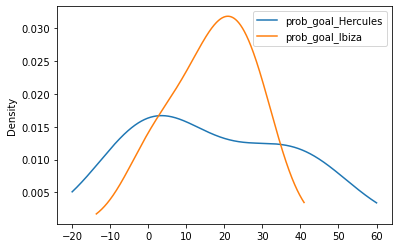

In [62]:
minutes_prob_goal_DF.plot( kind = 'density')
plt.savefig('../Technical_report/images/density_prob_score.png', dpi=None, bbox_inches="tight") 

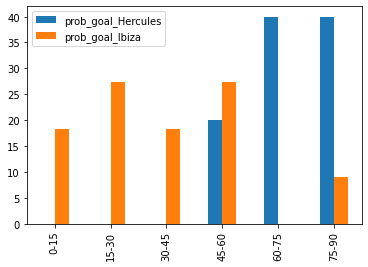

In [16]:
minutes_prob_goal_DF.plot(kind = 'bar')
plt.savefig('../Technical_report/images/barplot_prob_score.png', dpi=None, bbox_inches="tight") 

In [ ]:
minutes_prob_goal_DF.to_excel("../dataset/minutes_prob_goal.xlsx",
             sheet_name='both_team')
age_yellow_red_home_team_df.to_excel("../dataset/cards_goals_home_team.xlsx",
             sheet_name='home_team')
age_yellow_red_away_team_df.to_excel("../dataset/cards_goals_away_team.xlsx",
             sheet_name='away_team')

**Concatanate 2 DF both teams for further exploration in Tableau**

In [13]:
xls_home_team = pd.ExcelFile('../dataset/Home_team.xlsx')
xls_away_team = pd.ExcelFile('../dataset/Away_team.xlsx')

sheet1_away = xls_away_team.parse(0)
sheet1_home = xls_home_team.parse(0)
df1 = pd.DataFrame(sheet1_home)
df2 = pd.DataFrame(sheet1_away)

tableau = pd.concat([df1, df2])
tableau.to_excel("../dataset/Report.xlsx",
             sheet_name='both_teams')

## Regression linear between yellows card and minutes played : Home_team

                                 OLS Regression Results                                
Dep. Variable:           yellow_cards   R-squared (uncentered):                   0.404
Model:                            OLS   Adj. R-squared (uncentered):              0.380
Method:                 Least Squares   F-statistic:                              16.93
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                    0.000369
Time:                        20:55:30   Log-Likelihood:                         -31.590
No. Observations:                  26   AIC:                                      65.18
Df Residuals:                      25   BIC:                                      66.44
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

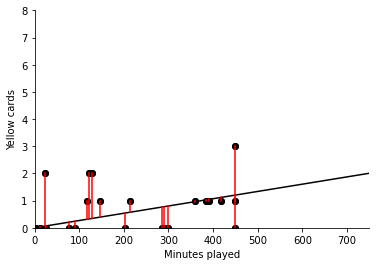

<Figure size 432x288 with 0 Axes>

In [14]:
#Some made up data

yellow_cards = age_yellow_red_home_team_df['Tarjetas amarillas'].values
minutes_played= np.array(age_yellow_red_home_team_df['Minutos jugados'].values)

#Set up dataframe
minutes_model = pd.DataFrame()
minutes_model = minutes_model.assign(minutes=minutes_played)
minutes_model = minutes_model.assign(goals=yellow_cards)

fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, yellow_cards, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Yellow cards')
ax.set_xlabel('Minutes played')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((0,750))
plt.ylim((0,8))


#Intercept
a=0


#Slope determined by linear regression
model_fit=smf.ols(formula='yellow_cards ~ minutes_played -1 ', data=minutes_model).fit()
print(model_fit.summary())        
[b]=model_fit.params

x=np.arange(800,step=0.1)
y= a + b*x 

ax.plot(minutes_played, yellow_cards, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(x, y, color='black')

#Show distances to line
for i,mp in enumerate(minutes_played):
    ax.plot([mp,mp],[yellow_cards[i],a+b*mp], color='red')


plt.show()
plt.savefig('../Technical_report/images/r_line_home_team.png', dpi=None, bbox_inches="tight")  


##  Regression linear between yellows card and minutes played : Away_team

                                 OLS Regression Results                                
Dep. Variable:           yellow_cards   R-squared (uncentered):                   0.358
Model:                            OLS   Adj. R-squared (uncentered):              0.333
Method:                 Least Squares   F-statistic:                              14.49
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                    0.000772
Time:                        20:55:48   Log-Likelihood:                         -32.822
No. Observations:                  27   AIC:                                      67.64
Df Residuals:                      26   BIC:                                      68.94
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

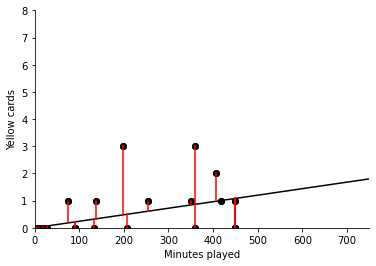

<Figure size 432x288 with 0 Axes>

In [15]:
#Some made up data

yellow_cards = age_yellow_red_away_team_df['Tarjetas amarillas'].values
minutes_played= np.array(age_yellow_red_away_team_df['Minutos jugados'].values)

#Set up dataframe
minutes_model = pd.DataFrame()
minutes_model = minutes_model.assign(minutes=minutes_played)
minutes_model = minutes_model.assign(goals=yellow_cards)

fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, yellow_cards, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Yellow cards')
ax.set_xlabel('Minutes played')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((0,750))
plt.ylim((0,8))


#Intercept
a=0


#Slope determined by linear regression
model_fit=smf.ols(formula='yellow_cards ~ minutes_played -1 ', data=minutes_model).fit()
print(model_fit.summary())        
[b]=model_fit.params

x=np.arange(800,step=0.1)
y= a + b*x 

ax.plot(minutes_played, yellow_cards, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(x, y, color='black')

#Show distances to line
for i,mp in enumerate(minutes_played):
    ax.plot([mp,mp],[yellow_cards[i],a+b*mp], color='red')


plt.show()
plt.savefig('../Technical_report/images/r_line_away_team.png', dpi=None, bbox_inches="tight")  


## Probability goals scored (example)

Liverpool against Burnley expect to score: 1    2.29226
dtype: float64
Burnley against Liverpool expect to score: 1    0.836963
dtype: float64
Liverpool: 4
Burnley: 2


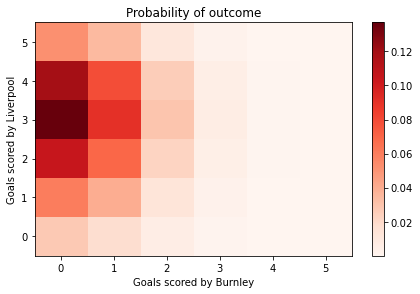

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

epl = pd.read_csv("http://www.football-data.co.uk/mmz4281/1920/E0.csv")
ep = epl[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl.head()

epl = epl[:-10]
epl.mean()

# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

#Fit the model to the data
#Home advantage included
#Team and opponent as fixed effects.
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()


home_team='Liverpool'
away_team='Burnley'

#Predict for Arsenal vs. Manchester City
home_score_rate=poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team,
                                       'home':1},index=[1]))
away_score_rate=poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team,
                                       'home':1},index=[1]))
print(home_team + ' against ' + away_team + ' expect to score: ' + str(home_score_rate))
print(away_team + ' against ' + home_team + ' expect to score: ' + str(away_score_rate))


#Lets just get a result
home_goals=np.random.poisson(home_score_rate)
away_goals=np.random.poisson(away_score_rate)
print(home_team + ': ' + str(home_goals[0]))
print(away_team + ': '  + str(away_goals[0]))


#Code to caluclate the goals for the match.
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
    
max_goals=5
score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)

fig=plt.figure()

#Make 2d histogram of results

from pylab import rcParams
rcParams['figure.figsize'] = 12/2.54, 8/2.54
ax=fig.add_subplot(1,1,1)

pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()
#fig.savefig('output/2DOutcomes.pdf' , dpi=None, bbox_inches="tight")

#Home, draw, away probabilities
homewin=np.sum(np.tril(score_matrix, -1))
draw=np.sum(np.diag(score_matrix))
awaywin=np.sum(np.triu(score_matrix, 1))